## ToDo : rajouter le score metier ?baggingclassifier et HistGradientBoostingClassifier(random_state = 22) , rajouter le scaler 

In [1]:
# Importer les bibliothèques nécessaires

import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, confusion_matrix,accuracy_score
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import missingno as msno
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import imblearn as imb
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from imblearn import FunctionSampler

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    base=pd.read_csv("/content/drive/MyDrive/Notebooks/P7/basep7.csv")
        
except ModuleNotFoundError :
    
    base = pd.read_csv("basep7.csv")
    
base = base.drop( columns = ['Unnamed: 0'])

In [3]:
# one_hot_encoder classique pour les non numériques
def one_hot_encoder(base, nan_as_category = True):
    original_columns = list(base.columns)
    categorical_columns = [col for col in base.columns if base[col].dtype == 'object']
    base2 = pd.get_dummies(base, columns= categorical_columns, dummy_na= True)
    new_columns = [c for c in base.columns if c not in original_columns]
    return base2
print (base.shape)
base2 =one_hot_encoder(base)
print (base2.shape)
base = base2

(307511, 122)
(307511, 262)


In [4]:
# Remplacer les valeurs manquantes par la moyenne de la colonne
base = base.fillna(base.mean())

In [5]:
# Séparer les variables explicatives (X) et la variable cible (y)
X = base.drop("TARGET", axis=1)
y = base["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [6]:
# Améliore l'affichage des DataFrame de résultats. 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# fonction comparer algos


In [7]:
def comp_algos(X,y,algos,params,cvi,scorer,sampling) : 

    
    roc_aucs = []
    confusions = []
    Report_df = pd.DataFrame(columns=['Algorithme', 'score nom ','score']) 
    Append = []

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #random_state ? 
    
    # Apply oversampling
    #ros = RandomOverSampler(random_state=42)
    #X_resampled, y_resampled = sampling.fit_resample(X_train,y_train)
    
    for i in range(len(algos)): 
        
        #faire boucle sur le sampling 
        for s in range(len(sampling)): 
            
            # Apply sampling
            #ros = RandomOverSampler(random_state=42)
            debut = time.time()
            X_resampled, y_resampled = sampling[s].fit_resample(X_train,y_train)

# Créer un objet GridSearchCV qui va comparer les performances des algorithmes sur les données en utilisant le score roc_auc comme critère d'évaluation 
            print (algos[i], params[i] )
    
            """numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])  

            reg = Pipeline(steps=[('preprocessor', numeric_transformer),
                      ('regression', estimator) ])""" 
            grid = GridSearchCV(estimator=algos[i], param_grid=params[i], scoring=scorer, cv=cvi, refit= True )


# Lancer la recherche des meilleurs paramètres et du meilleur algorithme 
            grid.fit(X_resampled,y_resampled)

# Afficher le meilleur score et le meilleur algorithme trouvé par GridSearchCV 
            print("Meilleur score:", grid.best_score_)
            print("Meilleur algorithme:", grid.best_estimator_)
            #print ( "cv results ;", grid.cv_results_ ) 
            print ( "best_params_",grid.best_params_)
            print ("best_index_",grid.best_index_)
            print ("scorer_",grid.scorer_)
            print ("n_splits_",grid.n_splits_)
            print ("sampling method",sampling[s])
    
            cv_result= pd.DataFrame(grid.cv_results_)
            display ( cv_result )

# Prédire les classes pour chaque algorithme 
            pred_y_train = grid.predict(X_train)
            score = accuracy_score(y_train,pred_y_train)
            print ('accuracy train',score)
          
            roc_auc_train = roc_auc_score(y_train, pred_y_train)
            print ( 'roc_auc_train',roc_auc_train)

            pred_y_train_proba=grid.predict_proba(X_train)[:,1]
            roc_auc_discret_train = roc_auc_score(y_train, pred_y_train_proba)
            print( "Roc auc train predict proba",roc_auc_discret_train)
        
            pred_y_test = grid.predict(X_test)
            score = accuracy_score(y_test,pred_y_test)
            print ('accuracy test',score)
          
            roc_auc_test = roc_auc_score(y_test, pred_y_test)
            print ( 'roc_auc_ test ',roc_auc_test)

            pred_y_test_proba=grid.predict_proba(X_test)[:,1]
            roc_auc_discret_test= roc_auc_score(y_test, pred_y_test_proba)
            print( "Roc auc score test predict proba",roc_auc_discret_test)

# Calculer la matrice de confusion pour chaque algorithme

            matrice_confusion = confusion_matrix(y_true=y_train,y_pred=pred_y_train)
            tn, fp, fn, tp = confusion_matrix(y_true=y_train,y_pred=pred_y_train, normalize='all').ravel()

# Change figure size and increase dpi for better resolution
            plt.figure(figsize=(2,1), dpi=100)
# Scale up the size of all text
            sns.set(font_scale = 1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
            ax = sns.heatmap(matrice_confusion, annot=True, fmt='d', )

# set x-axis label and ticks. 
            ax.set_xlabel("Prédiction ", fontsize=14, labelpad=20)
            ax.xaxis.set_ticklabels(['Accepté', 'Refus'])

# set y-axis label and ticks
            ax.set_ylabel("réel ", fontsize=14, labelpad=20)
            ax.yaxis.set_ticklabels(['Accepté', 'Refus'])

# set plot title
            titre = str(algos[i])
            ax.set_title(titre, fontsize=14, pad=20)
            plt.show()    
     
    
#graphique

            roc_auc_courbe = roc_auc_score(y_train, pred_y_train_proba)
            print ('roc auc courbe',roc_auc_courbe)
            fpr,tpr,_= roc_curve(y_train,pred_y_train_proba)
    
            plt.plot(fpr,tpr,label ='score (auc roc = %0.2f)' % roc_auc)
            plt.plot([0,1],[0,1],'k--',label ="random")
            plt.xlabel('Taux faux positifs')
            plt.ylabel('Taux vrais positifs')
            plt.title('ROC curve '+titre)
            plt.legend(loc = 'lower right')
            plt.show()
            
           
            
            # Créer un dataframe pandas qui contient les résultats de chaque algorithme
            print(' score ', scorer,':' ,grid.best_score_)
            duration = (time.time() - debut )/60
            print ((duration ,'minutes')
            Append = pd.DataFrame([[ algos[i],grid.best_params_,scorer ,grid.best_score_,sampling[s],roc_auc_train,roc_auc_discret_train
                                    ,roc_auc_test,roc_auc_discret_test,tn,fp,fn,tp,duration]]
                                  ,columns=['Algorithme','Meilleur param', 'score nom ','best score','sampling','roc_auc_train'
                                            ,'Roc_auc_train_discret','roc_auc_test','roc_auc_discret_test','TN','FP','FN','TP',"minutes"])
            Report_df = pd.concat([Report_df, Append]) 
            
    return Report_df

# test de base , scorer roc auc

DecisionTreeClassifier(random_state=22) {'max_depth': [3], 'min_samples_leaf': [5]}
Meilleur score: 0.6828603604217047
Meilleur algorithme: DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=22)
best_params_ {'max_depth': 3, 'min_samples_leaf': 5}
best_index_ 0
scorer_ make_scorer(roc_auc_score, needs_threshold=True)
n_splits_ 3
sampling method FunctionSampler(func=<function nosamplerfunc at 0x000001C4D8838318>)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.294564,0.086019,0.147585,0.008796,3,5,"{'max_depth': 3, 'min_samples_leaf': 5}",0.683964,0.690057,0.67456,0.68286,0.006375,1


accuracy train 0.9198969139214985
roc_auc_train 0.5
Roc auc train predict proba 0.6841204538901865
accuracy test 0.916768287725802
roc_auc_ test  0.5
Roc auc score test predict proba 0.6803956859657296


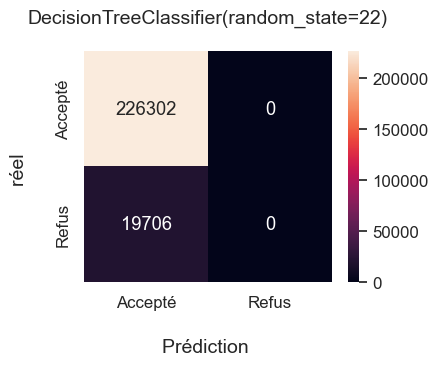

roc auc courbe 0.6841204538901865


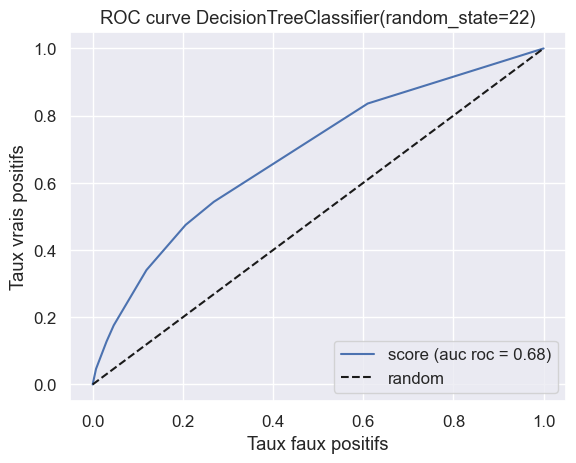

 score scorer ) 0.6828603604217047
0.2195719798405965 minutes
DecisionTreeClassifier(random_state=22) {'max_depth': [3], 'min_samples_leaf': [5]}
Meilleur score: 0.688983877334224
Meilleur algorithme: DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=22)
best_params_ {'max_depth': 3, 'min_samples_leaf': 5}
best_index_ 0
scorer_ make_scorer(roc_auc_score, needs_threshold=True)
n_splits_ 3
sampling method RandomOverSampler(random_state=22)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.363028,0.171473,0.269333,0.012201,3,5,"{'max_depth': 3, 'min_samples_leaf': 5}",0.688371,0.689721,0.68886,0.688984,0.000558,1


accuracy train 0.713395499333355
roc_auc_train 0.6504793312575543
Roc auc train predict proba 0.6892022471069388
accuracy test 0.7141115067557681
roc_auc_ test  0.6480798150443952
Roc auc score test predict proba 0.6871489758281837


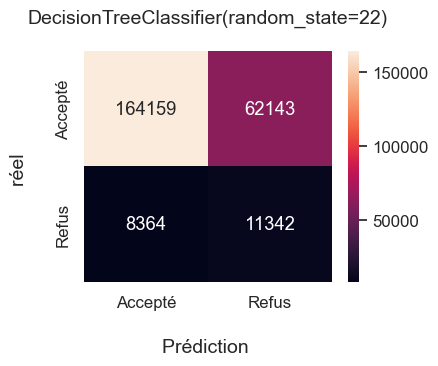

roc auc courbe 0.6892022471069388


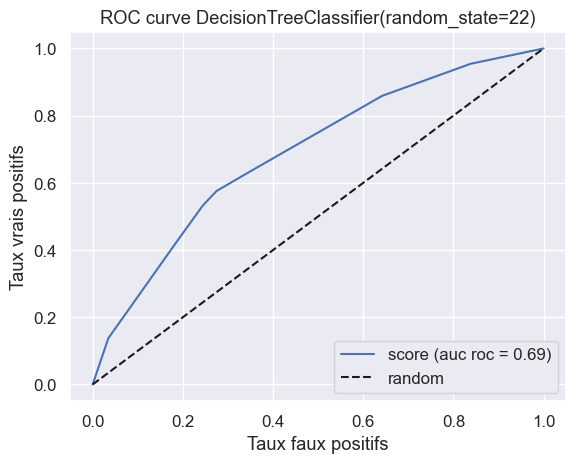

 score scorer ) 0.688983877334224
0.6665385007858277 minutes
DecisionTreeClassifier(random_state=22) {'max_depth': [3], 'min_samples_leaf': [5]}
Meilleur score: 0.6902709412248201
Meilleur algorithme: DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=22)
best_params_ {'max_depth': 3, 'min_samples_leaf': 5}
best_index_ 0
scorer_ make_scorer(roc_auc_score, needs_threshold=True)
n_splits_ 3
sampling method RandomUnderSampler(random_state=22)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.337499,0.02586,0.025248,0.000449,3,5,"{'max_depth': 3, 'min_samples_leaf': 5}",0.688785,0.692937,0.689092,0.690271,0.001889,1


accuracy train 0.71207440408442
roc_auc_train 0.6503635164431707
Roc auc train predict proba 0.6879955462890728
accuracy test 0.7126319041347576
roc_auc_ test  0.6478056939089177
Roc auc score test predict proba 0.6858341353760079


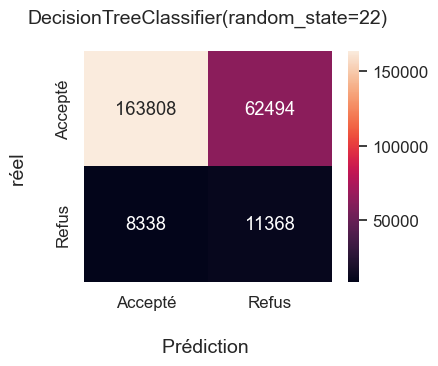

roc auc courbe 0.6879955462890728


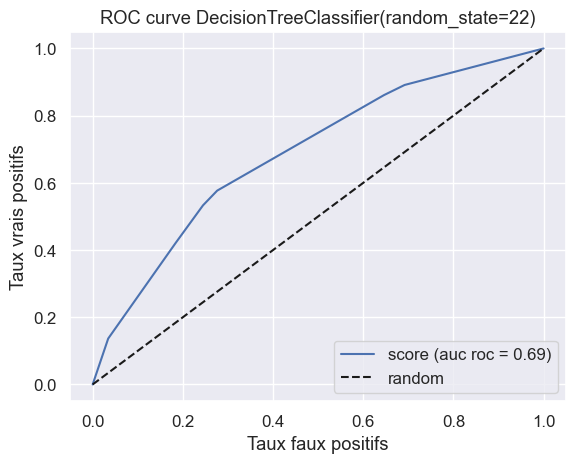

 score scorer ) 0.6902709412248201
0.7295141776402791 minutes
DecisionTreeClassifier(random_state=22) {'max_depth': [3], 'min_samples_leaf': [5]}
Meilleur score: 0.8174767938289875
Meilleur algorithme: DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=22)
best_params_ {'max_depth': 3, 'min_samples_leaf': 5}
best_index_ 0
scorer_ make_scorer(roc_auc_score, needs_threshold=True)
n_splits_ 3
sampling method SMOTETomek(random_state=22)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.776882,0.245682,0.253634,0.010485,3,5,"{'max_depth': 3, 'min_samples_leaf': 5}",0.779346,0.837986,0.835098,0.817477,0.026988,1


accuracy train 0.7206594907482683
roc_auc_train 0.5937159412760694
Roc auc train predict proba 0.6237810000653498
accuracy test 0.7153147000959302
roc_auc_ test  0.5889685394672626
Roc auc score test predict proba 0.6183779648231345


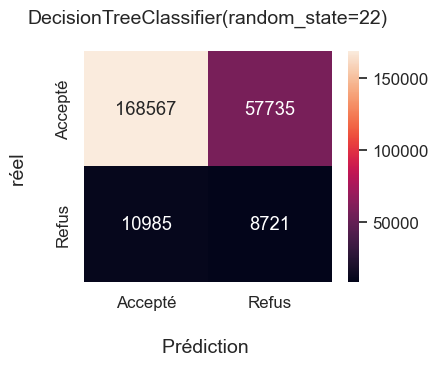

roc auc courbe 0.6237810000653498


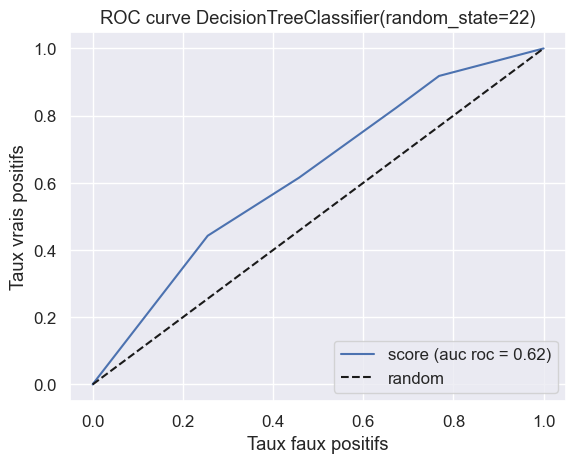

 score scorer ) 0.8174767938289875
80.27033323049545 minutes


,Algorithme,score nom,score,Meilleur param,sampling,roc_auc_train,Roc_auc_train_discret,roc_auc_test,roc_auc_courbe_test,TN,FP,FN,TP
0,DecisionTreeClassifier(random_state=22),roc_auc,0.682860,"{'max_depth': 3, 'min_samples_leaf': 5}",FunctionSampler(func=<function nosamplerfunc at 0x000001C4D8838318>),0.684120,0.684120,0.500000,0.680396,0.919897,0.000000,0.080103,0.000000
0,DecisionTreeClassifier(random_state=22),roc_auc,0.688984,"{'max_depth': 3, 'min_samples_leaf': 5}",RandomOverSampler(random_state=22),0.689202,0.689202,0.648080,0.687149,0.667291,0.252606,0.033999,0.046104
0,DecisionTreeClassifier(random_state=22),roc_auc,0.690271,"{'max_depth': 3, 'min_samples_leaf': 5}",RandomUnderSampler(random_state=22),0.687996,0.687996,0.647806,0.685834,0.665865,0.254032,0.033893,0.046210
0,DecisionTreeClassifier(random_state=22),roc_auc,0.817477,"{'max_depth': 3, 'min_samples_leaf': 5}",SMOTETomek(random_state=22),0.623781,0.623781,0.588969,0.618378,0.685209,0.234687,0.044653,0.035450


In [8]:
"""algos = [ LogisticRegression(random_state=22),DecisionTreeClassifier(random_state=22), RandomForestClassifier(random_state=22), 
         XGBClassifier(random_state=22), GaussianNB(),DummyClassifier()]

# Définir une grille de paramètres à optimiser pour chaque algorithme
params = [
    
    {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2", "elasticnet", 'none']}, # pour LogisticRegression 
    {"max_depth": [3, 5, 7], "min_samples_leaf": [5, 10, 15]}, # pour DecisionTreeClassifier
    {"n_estimators": [100, 200], "max_depth": [3, 5]}, # pour RandomForestClassifier 
    {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}, # pour XGBClassifier 
    {} ,# pas de paramètres à optimiser pour GaussianNB 
    {"strategy": ["most_frequent","prior","stratified","uniform"]}, # pour DummyClassifier
] """

algos = [ DecisionTreeClassifier(random_state=22)]
params = [ {"max_depth": [3], "min_samples_leaf": [5]}] # pour DecisionTreeClassifier

cvi =3
scorer = "roc_auc" 
def nosamplerfunc(X, y):
    return X[:], y[:]
nosampler = FunctionSampler(func=nosamplerfunc)


sampling = [nosampler, RandomOverSampler(random_state=22),RandomUnderSampler(random_state=22),SMOTETomek(random_state=22)]



#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
result_auc= comp_algos(X,y,algos,params,cvi,scorer,sampling)

result_auc


In [10]:
result_auc.to_excel('result_auc.xlsx')

# test avec scorer métier 

In [ ]:
""" algos = [ LogisticRegression(random_state=22),DecisionTreeClassifier(random_state=22), RandomForestClassifier(random_state=22), 
         XGBClassifier(random_state=22), GaussianNB(),DummyClassifier()]

# Définir une grille de paramètres à optimiser pour chaque algorithme
params = [
    
    {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2", "elasticnet", None]}, # pour LogisticRegression ‘l1’, ‘l2’, ‘elasticnet’, None
    {"max_depth": [3, 5, 7], "min_samples_leaf": [5, 10, 15]}, # pour DecisionTreeClassifier
    {"n_estimators": [100, 200], "max_depth": [3, 5]}, # pour RandomForestClassifier 
    {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}, # pour XGBClassifier 
    {} ,# pas de paramètres à optimiser pour GaussianNB 
    {"strategy": ["most_frequent","prior","stratified","uniform"]}, # pour DummyClassifier
]
"""
cvi =3

algos = [ DecisionTreeClassifier(random_state=22)]
params = [ {"max_depth": [3], "min_samples_leaf": [5]}] # pour DecisionTreeClassifier

def custom_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    score = tp + tn - fp -( 10 * fn)
    #score 2 = tp + (10 * tn )- fp -(10 * fn)
    return score

# Création du scorer personnalisé
score_metier= make_scorer(custom_score_func)

scorer = [score_metier]

sampling = [nosampler, RandomOverSampler(random_state=22),RandomUnderSampler(random_state=22),SMOTETomek(random_state=22)]



result_metier= comp_algos(X,y,algos,params,cvi,scorer,sampling)
result_metier

In [ ]:

result_auc.to_excel('result_auc.xlsx')

In [ ]:
STOP

# unbalanced  oversampling score roc auc 

In [ ]:
algos = [ LogisticRegression(random_state=22),DecisionTreeClassifier(random_state=22), RandomForestClassifier(random_state=22), XGBClassifier(random_state=22), GaussianNB(),DummyClassifier()]

# Définir une grille de paramètres à optimiser pour chaque algorithme
params = [
    
    {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2", "elasticnet", None]}, # pour LogisticRegression ‘l1’, ‘l2’, ‘elasticnet’, None
    {"max_depth": [3, 5, 7], "min_samples_leaf": [5, 10, 15]}, # pour DecisionTreeClassifier
    {"n_estimators": [100, 200], "max_depth": [3, 5]}, # pour RandomForestClassifier 
    {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}, # pour XGBClassifier 
    {} ,# pas de paramètres à optimiser pour GaussianNB 
    {"strategy": ["most_frequent","prior","stratified","uniform"]}, # pour DummyClassifier
]

cvi =2
scorer = "roc_auc"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Apply oversampling
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train,y_train)


comp_algos(X_resampled,y_resampled,X_test,y_test,algos,params,cvi,scorer)


# Nouvelle section

# Nouvelle section

# unbalanced  oversampling score métier 1 

In [ ]:
algos = [ LogisticRegression(random_state=22),DecisionTreeClassifier(random_state=22), RandomForestClassifier(random_state=22), XGBClassifier(random_state=22), GaussianNB(),DummyClassifier()]

# Définir une grille de paramètres à optimiser pour chaque algorithme
params = [
    
    {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2", "elasticnet", None]}, # pour LogisticRegression ‘l1’, ‘l2’, ‘elasticnet’, None
    {"max_depth": [3, 5, 7], "min_samples_leaf": [5, 10, 15]}, # pour DecisionTreeClassifier
    {"n_estimators": [100, 200], "max_depth": [3, 5]}, # pour RandomForestClassifier 
    {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}, # pour XGBClassifier 
    {} ,# pas de paramètres à optimiser pour GaussianNB 
    {"strategy": ["most_frequent","prior","stratified","uniform"]}, # pour DummyClassifier
]

cvi =2

def custom_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    score = tp + tn - fp -( 10 * fn)
    #score 2 tp + (10 * tn )- fp -(10 * fn)
    return score

# Création du scorer personnalisé
scorer = make_scorer(custom_score_func)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Apply oversampling
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train,y_train)


#comp_algos(X_resampled,y_resampled,X_test,y_test,algos,params,cvi,scorer)
comp_algos(X,y,algos,params,cvi,scorer,sampling)

# undersampling  roc auc

In [ ]:
algos = [ LogisticRegression(random_state=22),DecisionTreeClassifier(random_state=22), RandomForestClassifier(random_state=22), XGBClassifier(random_state=22), GaussianNB(),DummyClassifier()]

# Définir une grille de paramètres à optimiser pour chaque algorithme
params = [
    
    {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2", "elasticnet", None]}, # pour LogisticRegression ‘l1’, ‘l2’, ‘elasticnet’, None
    {"max_depth": [3, 5, 7], "min_samples_leaf": [5, 10, 15]}, # pour DecisionTreeClassifier
    {"n_estimators": [100, 200], "max_depth": [3, 5]}, # pour RandomForestClassifier 
    {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}, # pour XGBClassifier 
    {} ,# pas de paramètres à optimiser pour GaussianNB 
    {"strategy": ["most_frequent","prior","stratified","uniform"]}, # pour DummyClassifier
]

cvi =2
scorer = "roc_auc"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Apply undersampling
rus = RandomUnderSampler(random_state=22)
X_resampled, y_resampled = rus.fit_resample(X_train,y_train)


comp_algos(X_resampled,y_resampled,X_test,y_test,algos,params,cvi,scorer)

# undersampling score metier 1

In [ ]:
algos = [ LogisticRegression(random_state=22),DecisionTreeClassifier(random_state=22), RandomForestClassifier(random_state=22), XGBClassifier(random_state=22), GaussianNB(),DummyClassifier()]

# Définir une grille de paramètres à optimiser pour chaque algorithme
params = [
    
    {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2", "elasticnet", None]}, # pour LogisticRegression ‘l1’, ‘l2’, ‘elasticnet’, None
    {"max_depth": [3, 5, 7], "min_samples_leaf": [5, 10, 15]}, # pour DecisionTreeClassifier
    {"n_estimators": [100, 200], "max_depth": [3, 5]}, # pour RandomForestClassifier 
    {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}, # pour XGBClassifier 
    {} ,# pas de paramètres à optimiser pour GaussianNB 
    {"strategy": ["most_frequent","prior","stratified","uniform"]}, # pour DummyClassifier
]

cvi =2

def custom_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    score = tp + tn - fp -( 10 * fn)
    #score 2 tp + (10 * tn )- fp -(10 * fn)
    return score

# Création du scorer personnalisé
scorer = make_scorer(custom_score_func)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Apply undersampling
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train,y_train)


comp_algos(X_resampled,y_resampled,X_test,y_test,algos,params,cvi,scorer)

# Unbalanced SMOTE roc auc

In [ ]:
algos = [ LogisticRegression(random_state=22),DecisionTreeClassifier(random_state=22), RandomForestClassifier(random_state=22), XGBClassifier(random_state=22), GaussianNB(),DummyClassifier()]

# Définir une grille de paramètres à optimiser pour chaque algorithme
params = [
    
    {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2", "elasticnet", None]}, # pour LogisticRegression ‘l1’, ‘l2’, ‘elasticnet’, None
    {"max_depth": [3, 5, 7], "min_samples_leaf": [5, 10, 15]}, # pour DecisionTreeClassifier
    {"n_estimators": [100, 200], "max_depth": [3, 5]}, # pour RandomForestClassifier 
    {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}, # pour XGBClassifier 
    {} ,# pas de paramètres à optimiser pour GaussianNB 
    {"strategy": ["most_frequent","prior","stratified","uniform"]}, # pour DummyClassifier
]

cvi =2
scorer = "roc_auc"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Apply SMOTE
smote = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train,y_train)

comp_algos(X_resampled,y_resampled,X_test,y_test,algos,params,cvi,scorer)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Unbalanced SMOTE métier 1

In [ ]:
algos = [ LogisticRegression(random_state=22),DecisionTreeClassifier(random_state=22), RandomForestClassifier(random_state=22), XGBClassifier(random_state=22), GaussianNB(),DummyClassifier()]

# Définir une grille de paramètres à optimiser pour chaque algorithme
params = [
    
    {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2", "elasticnet", None]}, # pour LogisticRegression ‘l1’, ‘l2’, ‘elasticnet’, None
    {"max_depth": [3, 5, 7], "min_samples_leaf": [5, 10, 15]}, # pour DecisionTreeClassifier
    {"n_estimators": [100, 200], "max_depth": [3, 5]}, # pour RandomForestClassifier 
    {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}, # pour XGBClassifier 
    {} ,# pas de paramètres à optimiser pour GaussianNB 
    {"strategy": ["most_frequent","prior","stratified","uniform"]}, # pour DummyClassifier
]

cvi =2

def custom_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    score = tp + tn - fp -( 10 * fn)
    #score 2 tp + (10 * tn )- fp -(10 * fn)
    return score

# Création du scorer personnalisé
scorer = make_scorer(custom_score_func)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Apply SMOTE
smote = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train,y_train)

comp_algos(X_resampled,y_resampled,X_test,y_test,algos,params,cvi,scorer)

# individuel

In [ ]:
#LogisticRegression() {'C': 1, 'penalty': 'l2'} 
grid = GridSearchCV(estimator=algos[i], param_grid=params[i], scoring="roc_auc", cv=3, refit= True )

In [ ]:

nsplit = 3
    
    
debut = time.time()



estimator = DecisionTreeClassifier(max_depth=7, min_samples_leaf=15)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])  

clf = Pipeline(steps=[ #('preprocessor', numeric_transformer),
                      ('estimator', estimator) ])


skf = StratifiedKFold(n_splits=nsplit, shuffle=True,random_state=22 ) 


for train_index, test_index in skf.split(X, y):
    x_train, x_test = X.iloc[train_index] , X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(x_train, y_train) 

    
#c faire tourner le prédict
pred_y = clf.predict(x_test)
score = accuracy_score(y_test,pred_y)
print ('accuracy test ',score)
roc_auc = roc_auc_score(y_test, pred_y)
print ( 'roc_auc_  test ',roc_auc)


pred_y_train = clf.predict(x_train)
score = accuracy_score(y_train,pred_y_train)
print ('accuracy train ',score)
roc_auc = roc_auc_score(y_train, pred_y_train)
print ( 'roc_auc_  train ',roc_auc)

In [ ]:

nsplit = 3
    
    
debut = time.time()

grid = GridSearchCV(estimator=DecisionTreeClassifier(), 
                                param_grid={"max_depth": [3, 5, 7], "min_samples_leaf": [5, 10, 15]}, scoring="roc_auc", cv=3, refit= True )


grid.fit(X,y)

# Afficher le meilleur score et le meilleur algorithme trouvé par GridSearchCV 
print("Meilleur score:", grid.best_score_)
print("Meilleur algorithme:", grid.best_estimator_)




In [ ]:
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit GridSearchCV on training data
grid = GridSearchCV(estimator=DecisionTreeClassifier(), 
                    param_grid={"max_depth": [3, 5, 7], "min_samples_leaf": [5, 10, 15]}, 
                    scoring="roc_auc", cv=3)
grid.fit(X_train,y_train)

# Make predictions on test data using best_estimator_
y_pred = grid.best_estimator_.predict_proba(X_test)[:,1]

# Calculate FPR and TPR
fpr, tpr, thresholds = roc_curve(y_test,y_pred)

# Calculate AUC
roc_auc = auc(fpr,tpr)

# Plot ROC curve
plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
grid = GridSearchCV(estimator=DecisionTreeClassifier, param_grid={"max_depth": [3, 5, 7], "min_samples_leaf": [5, 10, 15]}, scoring="roc_auc", cv=3, refit= True )

In [ ]:

      
    
    
    
""" Append= pd.DataFrame([['RandomForest' , 
                        np.around (mean_squared_error(y_test,reg.predict(x_test)),3),
                       np.around (mean_squared_error(y_test,reg.predict(x_test),squared=False),3),
                      np.around(r2_score(y_test,reg.predict(x_test)),3),
                     np.around( mean_absolute_percentage_error(y_test,reg.predict(x_test)),3),
                      np.around(r2_score(y_train,reg.predict(x_train)),3) ,
                      time.time() - debut]], 
                     columns=['méthode', 'MSE','RMSE','R2 Test','MA%E','R2 Train','Durée'])
    

Report = pd.concat([Report, Append]) 
Report""" 
    

In [ ]:


# Calculer le score roc_auc pour chaque algorithme 
    roc_aucs = []
    for i in range(len(algos)):
        roc_aucs.append(roc_auc_score(y_true=y,y_score=probas[:,i]))

# Créer un dataframe pandas qui contient les scores roc_auc de chaque algorithme 
    roc_df = pd.DataFrame({"Algorithme": algos,"ROC_AUC": roc_aucs})
    print(roc_df)

# Prédire les classes pour chaque algorithme 
    preds = grid.predict(X)

# Calculer la matrice de confusion pour chaque algorithme 
    confusions = []
    for i in range(len(algos)):
        confusions.append(confusion_matrix(y_true=y,y_pred=preds[:,i]))

# Créer un dataframe pandas qui contient les matrices de confusion de chaque algorithme 
    conf_df = pd.DataFrame({"Algorithme": algos,"Confusion Matrix": confusions})
    print(conf_df)

In [ ]:
# Importer la bibliothèque Keras Tuner qui permet de faire de l'optimisation bayésienne
from kerastuner.tuners import BayesianOptimization

# Définir une fonction qui crée un modèle de classification naïve bayésienne avec des hyperparamètres à optimiser
def build_model(hp):
    # Créer un objet GaussianNB 
    model = GaussianNB()
    # Définir les hyperparamètres à optimiser: le lissage de Laplace (var_smoothing) et le seuil de décision (threshold)
    hp_var_smoothing = hp.Float('var_smoothing', 1e-9, 1e-3, sampling='log')
    hp_threshold = hp.Float('threshold', 0.0, 1.0)
    # Affecter les valeurs des hyperparamètres au modèle 
    model.var_smoothing = hp_var_smoothing
    model.threshold = hp_threshold
    # Retourner le modèle 
    return model

# Créer un objet BayesianOptimization qui va comparer les performances du modèle sur les données en utilisant le score roc_auc comme critère d'évaluation 
tuner = BayesianOptimization(build_model,
                             objective='roc_auc',
                             max_trials=10,
                             executions_per_trial=1)

# Lancer la recherche des meilleurs hyperparamètres pour le modèle 
tuner.search(X,y)

# Afficher les meilleurs hyperparamètres trouvés par BayesianOptimization 
print("Meilleurs hyperparamètres:", tuner.get_best_hyperparameters()[0].values)

# Prédire les probabilités des classes pour le modèle optimisé 
proba_bayes = tuner.predict(X)

# Calculer le score roc_auc pour le modèle optimisé 
roc_auc_bayes = roc_auc_score(y_true=y,y_score=proba_bayes)

# Ajouter le score roc_auc du modèle optimisé au dataframe pandas qui contient les scores roc_auc de chaque algorithme 
roc_df.loc[len(roc_df)] = ["GaussianNB Optimized", roc_auc_bayes]
print(roc_df)

# Prédire les classes pour le modèle optimisé 
pred_bayes = tuner.predict_classes(X)

# Calculer la matrice de confusion pour le modèle optimisé 
confusion_bayes = confusion_matrix(y_true=y,y_pred=pred_bayes)

# Ajouter la matrice de confusion du modèle optimisé au dataframe pandas qui contient les matrices de confusion de chaque algorithme 
conf_df.loc[len(conf_df)] = ["GaussianNB Optimized", confusion_bayes]
print(conf_df)

In [ ]:
# Importer la bibliothèque matplotlib.pyplot qui permet de faire des graphiques 
import matplotlib.pyplot as plt

# Créer une figure avec une taille de 10x10 pouces 
plt.figure(figsize=(10,10))

# Parcourir chaque algorithme dans le dataframe roc_df qui contient les scores roc_auc de chaque algorithme 
for index, row in roc_df.iterrows():
    # Récupérer le nom de l'algorithme et le score roc_auc 
    algo = row["Algo"]
    score = row["ROC_AUC"]
    # Calculer les taux de faux positifs (fpr) et de vrais positifs (tpr) en utilisant la fonction roc_curve de sklearn.metrics 
    fpr, tpr, thresholds = roc_curve(y_true=y,y_score=proba_dict[algo])
    # Tracer la courbe ROC en utilisant la fonction plot de matplotlib.pyplot 
    plt.plot(fpr,tpr,label=f"{algo} (AUC={score:.3f})")

# Ajouter un titre au graphique 
plt.title("Courbes ROC des différents algorithmes")

# Ajouter des légendes aux axes x et y 
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")

# Ajouter une grille au graphique pour faciliter la lecture 
plt.grid()

# Ajouter une ligne diagonale qui représente un classifieur aléatoire 
plt.plot([0,1],[0,1],linestyle="--",color="black",label="Aléatoire")

# Ajouter une légende au graphique pour identifier chaque courbe ROC 
plt.legend()

# Afficher le graphique à l'écran 
plt.show()


Les courbes ROC permettent d’évaluer les performances d’un modèle de classification en fonction du seuil de décision choisi. Elles représentent le taux de vrais positifs (TPR) en fonction du taux de faux positifs (FPR) pour différents seuils. Plus la courbe est proche du coin supérieur gauche du graphique, plus le modèle est performant. L’aire sous la courbe (AUC) est une mesure synthétique qui résume la qualité d’un modèle: plus elle est proche de 1, mieux c’est.

Sur ce graphique, on peut voir que le modèle optimisé par l’optimisation bayésienne a la meilleure performance parmi tous les modèles testés. Il a une AUC élevée et il domine les autres courbes sur tout l’intervalle des FPR. Cela signifie qu’il a un bon compromis entre sensibilité et spécificité.

In [ ]:
# Importer les bibliothèques nécessaires
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import pandas as pd

# Créer un dataframe pandas avec les étiquettes réelles et les probabilités prédites
y_true = [0, 0, 0, 1, 1, 1]
y_pred = [0.1, 0.2, 0.3, 0.7, 0.8, 0.9]
df = pd.DataFrame({"y_true": y_true,"y_pred": y_pred})

# Calculer les taux de faux positifs et de vrais positifs pour chaque classe
fpr_0,tpr_0,_ = roc_curve(y_true=df["y_true"],y_score=1-df["y_pred"],pos_label=0)
fpr_1,tpr_1,_ = roc_curve(y_true=df["y_true"],y_score=df["y_pred"],pos_label=1)

# Créer un objet FacetGrid avec seaborn
g = sns.FacetGrid(df,hue="y_true",height=5)

# Appliquer la fonction plot à chaque sous-graphique avec la méthode map
g.map(plt.plot,fpr_0,tpr_0,label="Classe 0")
g.map(plt.plot,fpr_1,tpr_1,label="Classe 1")

# Ajouter des titres, des légendes et des annotations au graphique
g.set_axis_labels("Taux de faux positifs","Taux de vrais positifs")
g.fig.suptitle("Courbes ROC avec seaborn")
g.add_legend()
plt.plot([0,1],[0,1],linestyle="--",color="black",label="Aléatoire")
plt.show()

# 